# Data Preprocessing

## Load the dataset

In [2]:
import pandas as pd

df = pd.read_csv("data.csv", sep=";", dtype={'BillNo': str})

In [3]:
print(df.head())

   BillNo                             Itemname  Quantity              Date  \
0  536365   WHITE HANGING HEART T-LIGHT HOLDER         6  01.12.2010 08:26   
1  536365                  WHITE METAL LANTERN         6  01.12.2010 08:26   
2  536365       CREAM CUPID HEARTS COAT HANGER         8  01.12.2010 08:26   
3  536365  KNITTED UNION FLAG HOT WATER BOTTLE         6  01.12.2010 08:26   
4  536365       RED WOOLLY HOTTIE WHITE HEART.         6  01.12.2010 08:26   

  Price  CustomerID         Country  
0  2,55     17850.0  United Kingdom  
1  3,39     17850.0  United Kingdom  
2  2,75     17850.0  United Kingdom  
3  3,39     17850.0  United Kingdom  
4  3,39     17850.0  United Kingdom  


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BillNo      522064 non-null  object 
 1   Itemname    520609 non-null  object 
 2   Quantity    522064 non-null  int64  
 3   Date        522064 non-null  object 
 4   Price       522064 non-null  object 
 5   CustomerID  388023 non-null  float64
 6   Country     522064 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 27.9+ MB


## Data Cleaning

In [5]:
df.drop_duplicates(inplace=True)

# Count negative quantity rows
neg_qty_rows = df[df['Quantity'] < 0]
print("Total rows with negative Quantity: ", len(neg_qty_rows))
print(neg_qty_rows.head())

# Keep only positive quantity rows
df = df[df['Quantity'] >= 0]



Total rows with negative Quantity:  1336
      BillNo Itemname  Quantity              Date Price  CustomerID  \
2359  536589      NaN       -10  01.12.2010 16:50     0         NaN   
4289  536764      NaN       -38  02.12.2010 14:42     0         NaN   
6998  536996      NaN       -20  03.12.2010 15:30     0         NaN   
6999  536997      NaN       -20  03.12.2010 15:30     0         NaN   
7000  536998      NaN        -6  03.12.2010 15:30     0         NaN   

             Country  
2359  United Kingdom  
4289  United Kingdom  
6998  United Kingdom  
6999  United Kingdom  
7000  United Kingdom  


## Handle Missing Values

In [6]:
print("MISSING VALUES")
print(df.isnull().sum())

MISSING VALUES
BillNo             0
Itemname         592
Quantity           0
Date               0
Price              0
CustomerID    132631
Country            0
dtype: int64


In [7]:
df.dropna(subset=["CustomerID", "Itemname"], inplace=True)

## Cleaned Data

In [8]:
# Keep only specified columns
df = df[['BillNo', 'CustomerID', 'Itemname', 'Quantity']]

print(df.head(10))


   BillNo  CustomerID                             Itemname  Quantity
0  536365     17850.0   WHITE HANGING HEART T-LIGHT HOLDER         6
1  536365     17850.0                  WHITE METAL LANTERN         6
2  536365     17850.0       CREAM CUPID HEARTS COAT HANGER         8
3  536365     17850.0  KNITTED UNION FLAG HOT WATER BOTTLE         6
4  536365     17850.0       RED WOOLLY HOTTIE WHITE HEART.         6
5  536365     17850.0         SET 7 BABUSHKA NESTING BOXES         2
6  536365     17850.0    GLASS STAR FROSTED T-LIGHT HOLDER         6
7  536366     17850.0               HAND WARMER UNION JACK         6
8  536366     17850.0            HAND WARMER RED POLKA DOT         6
9  536367     13047.0        ASSORTED COLOUR BIRD ORNAMENT        32


# Clustering Analysis Using DBSCAN

## Build Basket

In [9]:
# (row = CustomerID, column = Itemname)
basket = df.groupby(['CustomerID', 'Itemname'])['Quantity'].sum().unstack().fillna(0)

## Convert Quantities to T/F (presence/absence)

In [10]:
customer_coded = basket > 0

## Standardize Data

In [11]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(customer_coded)

## PCA

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20, random_state=42)  # keep top 20 components
X_pca = pca.fit_transform(X)

print("Original shape:", X.shape)
print("Reduced shape:", X_pca.shape)

Original shape: (4297, 3846)
Reduced shape: (4297, 20)


## Implement DBSCAN algorithm

In [13]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=5, min_samples=5, metric="euclidean").fit(X_pca)
customer_coded['Cluster'] = db.labels_

print(customer_coded['Cluster'].value_counts())

Cluster
 0    2708
-1    1574
 2       9
 1       6
Name: count, dtype: int64


## Top Products per Cluster

In [14]:
for c in sorted(customer_coded['Cluster'].unique()):
    cluster_data = customer_coded[customer_coded['Cluster'] == c].drop('Cluster', axis=1)
    top_items = cluster_data.sum().sort_values(ascending=False).head(10)
    
    print("\nCluster", c)
    print("Number of customers:", len(cluster_data))
    print("Top products:\n", top_items)


Cluster -1
Number of customers: 1574
Top products:
 Itemname
REGENCY CAKESTAND 3 TIER              512
WHITE HANGING HEART T-LIGHT HOLDER    506
PACK OF 72 RETROSPOT CAKE CASES       446
JUMBO BAG RED RETROSPOT               426
SET OF 3 CAKE TINS PANTRY DESIGN      425
PARTY BUNTING                         419
LUNCH BAG RED RETROSPOT               398
PAPER CHAIN KIT 50'S CHRISTMAS        398
SPOTTY BUNTING                        389
ASSORTED COLOUR BIRD ORNAMENT         386
dtype: int64

Cluster 0
Number of customers: 2708
Top products:
 Itemname
REGENCY CAKESTAND 3 TIER              353
WHITE HANGING HEART T-LIGHT HOLDER    337
ASSORTED COLOUR BIRD ORNAMENT         285
PARTY BUNTING                         274
BAKING SET 9 PIECE RETROSPOT          230
NATURAL SLATE HEART CHALKBOARD        222
PAPER CHAIN KIT 50'S CHRISTMAS        209
JAM MAKING SET WITH JARS              208
SET OF 3 CAKE TINS PANTRY DESIGN      205
JUMBO BAG RED RETROSPOT               201
dtype: int64

Cluster 1


## Clusters (PCA Projection)

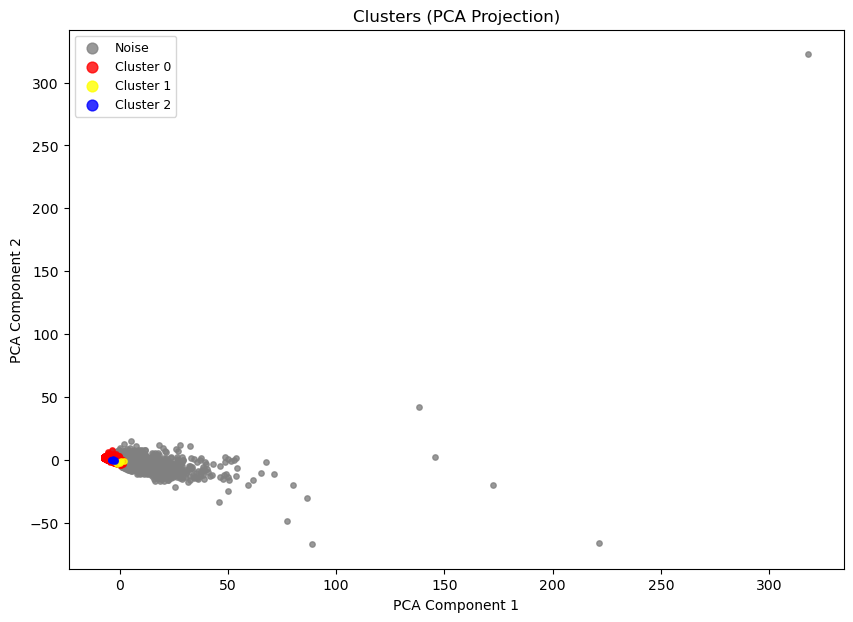

In [15]:
import matplotlib.pyplot as plt

labels = customer_coded['Cluster'].values

cluster_colors = {
    -1: "gray",      
     0: "red",       
     1: "yellow",      
     2: "blue"        
}

plt.figure(figsize=(10,7))

for lab, color in cluster_colors.items():
    mask = labels == lab
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        color=color, s=15, alpha=0.8, label=f"Cluster {lab}" if lab != -1 else "Noise"
    )

plt.title("Clusters (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(markerscale=2, fontsize=9)
plt.show()


# Market Basket Analysis Implementation

## Build basket for Cluster 0

In [16]:
cluster0_customers = customer_coded[customer_coded['Cluster'] == 0].index
cluster0_df = df[df['CustomerID'].isin(cluster0_customers)]
basket_cluster0 = (cluster0_df.groupby(['BillNo', 'Itemname'])['Quantity'].sum().unstack().fillna(0))

## Convert Quantities to T/F 

In [17]:
basket_cluster0_binary = basket_cluster0 > 0

## Frequent Itemsets

In [18]:
from mlxtend.frequent_patterns import fpgrowth, association_rules
frequent_itemsets_cluster0 = fpgrowth(
    basket_cluster0_binary, 
    min_support=0.005,   # (0.5% of baskets)
    use_colnames=True
)

print("Frequent Itemsets (min_support=0.005)")
print(frequent_itemsets_cluster0.head(20))
print("Total itemsets:", len(frequent_itemsets_cluster0))

Frequent Itemsets (min_support=0.005)
     support                               itemsets
0   0.078516   (WHITE HANGING HEART T-LIGHT HOLDER)
1   0.015642       (RED WOOLLY HOTTIE WHITE HEART.)
2   0.014415  (KNITTED UNION FLAG HOT WATER BOTTLE)
3   0.010888                  (WHITE METAL LANTERN)
4   0.010428         (SET 7 BABUSHKA NESTING BOXES)
5   0.008128       (CREAM CUPID HEARTS COAT HANGER)
6   0.005521    (GLASS STAR FROSTED T-LIGHT HOLDER)
7   0.017175               (HAND WARMER UNION JACK)
8   0.040178       (PAPER CHAIN KIT 50'S CHRISTMAS)
9   0.026376           (WOODEN FRAME ANTIQUE WHITE)
10  0.026376    (WOODEN PICTURE FRAME WHITE FINISH)
11  0.014415   (WOOD 2 DRAWER CABINET WHITE FINISH)
12  0.010888    (WOOD S/3 CABINET ANT WHITE FINISH)
13  0.009968                (EDWARDIAN PARASOL RED)
14  0.007054                  (SAVE THE PLANET MUG)
15  0.021929    (HOT WATER BOTTLE TEA AND SYMPATHY)
16  0.016409     (RED HANGING HEART T-LIGHT HOLDER)
17  0.033430              

## Generate Association Rules

In [19]:
rules_cluster0 = association_rules(
    frequent_itemsets_cluster0, 
    metric="confidence", 
    min_threshold=0.3  
)

print("Association Rules (confidence ≥0.3)")
print(rules_cluster0[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))
print("Total rules:", len(rules_cluster0))

Association Rules (confidence ≥0.3)
                                         antecedents  \
0              (KNITTED UNION FLAG HOT WATER BOTTLE)   
1                   (RED WOOLLY HOTTIE WHITE HEART.)   
2                       (WOODEN FRAME ANTIQUE WHITE)   
3                (WOODEN PICTURE FRAME WHITE FINISH)   
4                       (WOODEN FRAME ANTIQUE WHITE)   
5                (WOODEN PICTURE FRAME WHITE FINISH)   
6  (WHITE HANGING HEART T-LIGHT HOLDER, WOODEN PI...   
7  (WHITE HANGING HEART T-LIGHT HOLDER, WOODEN FR...   
8  (WOODEN PICTURE FRAME WHITE FINISH, WOODEN FRA...   
9               (WOOD 2 DRAWER CABINET WHITE FINISH)   

                             consequents   support  confidence       lift  
0       (RED WOOLLY HOTTIE WHITE HEART.)  0.005827    0.404255  25.844597  
1  (KNITTED UNION FLAG HOT WATER BOTTLE)  0.005827    0.372549  25.844597  
2   (WHITE HANGING HEART T-LIGHT HOLDER)  0.007974    0.302326   3.850518  
3           (WOODEN FRAME ANTIQUE WHITE)  0

## Sort association rules based on lift and confidence

In [20]:
rules_cluster0_sorted = rules_cluster0.sort_values(by=['lift', 'confidence'], ascending=False)

print("Rules Sorted")
print(rules_cluster0_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

Rules Sorted
                                           antecedents  \
407                    (GLASS APOTHECARY BOTTLE TONIC)   
406                   (GLASS APOTHECARY BOTTLE ELIXIR)   
390  (REGENCY TEA PLATE ROSES, REGENCY TEA PLATE GR...   
395                           (REGENCY TEA PLATE PINK)   
265                         (COFFEE MUG PEARS  DESIGN)   
266                         (COFFEE MUG APPLES DESIGN)   
391  (REGENCY TEA PLATE ROSES, REGENCY TEA PLATE PINK)   
394                          (REGENCY TEA PLATE GREEN)   
223                     (POPPY'S PLAYHOUSE LIVINGROOM)   
222                        (POPPY'S PLAYHOUSE BEDROOM)   

                                           consequents   support  confidence  \
407                   (GLASS APOTHECARY BOTTLE ELIXIR)  0.005061    0.673469   
406                    (GLASS APOTHECARY BOTTLE TONIC)  0.005061    0.804878   
390                           (REGENCY TEA PLATE PINK)  0.005981    0.812500   
395  (REGENCY TEA PLATE ROSE

## Outputs to CSV

In [21]:
rules_cluster0_sorted.to_csv("cluster0_rules_sorted.csv", index=False)